# Reinforcement learning from scratch: homework 1

## Andrew SaLoutos, April 30 2018

## EECS 495, Reinforcement Learning

## Homework 1 (completed iPython notebook)

### General instructions

Complete the exericse listed below in this Jupyter notebook - leaving all of your code in Python cells in the notebook itself.  Feel free to add any necessary cells.  

### When submitting this homework:

**Make sure you have put your name at the top of each file**
    
**Make sure all output is present in your notebook prior to submission**

In [3]:
# import custom libraries
from custom_library import basic_optimizers as optimizers
from custom_library import variable_order_plotters as plotter

# import autograd functionality
import autograd.numpy as np

# import path to datasets
datapath = 'datasets/'

# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook

# autoreload function - so if anything behind the scenes is changeed those changes
# are reflected in the notebook without having to restart the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### <span style="color:#a50e3e;">Exercise 1: </span>  Perform system identification on a small chunk of cruise control data 

In this exercise you will create a system model - denoted as $f_{\text{system}}$ in the [course notes](https://www.dropbox.com/s/m6456ze0fd8kaf8/system_identification_pid_notes.pdf?dl=0) - using a small snippet of cruise control data shown below.  Here our `output sequence` are states $\left\{s_t\right\}_{t=1}^T$, and the `input sequence` corresponding actions $\left\{a_t\right\}_{t=1}^{T-1}$ (we can ignore any finanl action $a_T$ since there is no next state $s_{t+1}$ to regress it on in learning our system model).  Notice at each update step the action is clipped to lie in the range $[-50,100]$ - which is the angle of the pedal against the floor of the car.  Here a negative angle indicates that 'regenerative braking' was applied.

<IPython.core.display.Javascript object>


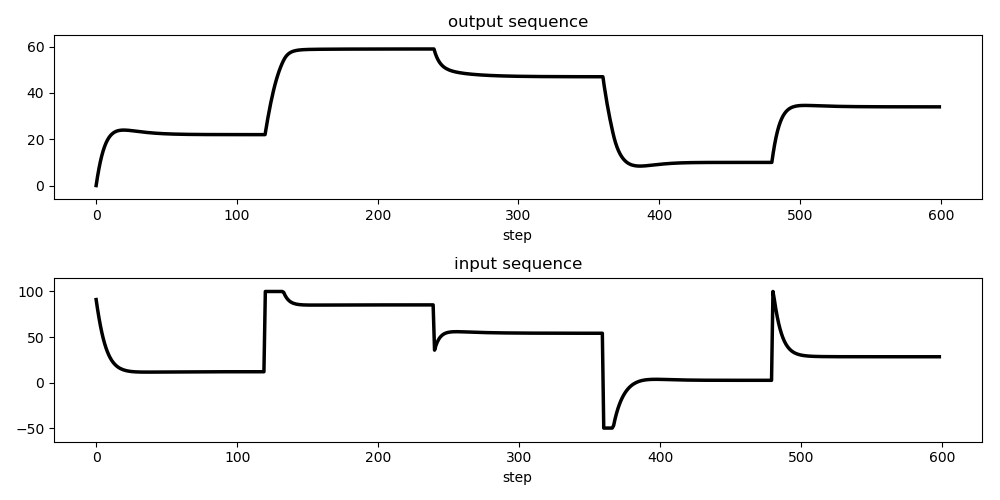

In [4]:
# load in cruise control data
data = np.loadtxt(datapath + 'cruise_control_data.csv',delimiter = ',')

# extract actions and states 
actions = data[0,1:][np.newaxis,:] # our T-1 actions
states = data[1,:][np.newaxis,:]   # our T states

# plot the test pair
plotter.plot_pair(actions,states)

Some more particulars: here you need to learn the weights of a basic order $1$ linear system model - which takes the form

\begin{equation}
s_{t+1} = f_{\text{system}}\left(s_t,a_t; \mathbf{w}_\text{system}\right) = w_0 + w_1s_t + w_2a_t
\end{equation}

by properly minimizing the associated Least Squares cost function

\begin{equation}
\frac{1}{T-1}\sum_{t=1}^{T-1}\left(f_{\text{system}}\left(s_t,a_t; \mathbf{w}_\text{system}\right) - s_{t+1}\right)^2
\end{equation}

over the weights $\mathbf{w}_{\text{system}} = \begin{bmatrix} w_0 \\ w_1 \\ w_2 \end{bmatrix}$ where $T$ is the length of our training action sequence.  


- Build a `Python` version of the system model and Least Squares cost function and minimize it using a first order method.  Use the entire dataset provided for training (i.e., do not worry about validation error)


- A simple full batch gradient descent module has been provided in file file `basic_optimizers.py` in the `custom_library` directory for use with this exercise.


- After properly minimizing the Least Squares cost above make a plot like the one shown below - which shows the original state data in black, and the system model approximation in blue.  Your trained model should be able to match the data quite well.

In [8]:
### system model

def g(w,a_train,s_train):
    ''' Least squares cost function '''
    
    J = 0
    
    T = s_train.shape[1]
    
    for ii in range(1,T-1):
        J = J + (w[0] + w[1]*s_train[0,ii] + w[2]*a_train[0,ii] - s_train[0,ii+1])**2
    
    J = J/(T-1)
    
    return J    

### minimize the least squares (using entire dataset) using full-batch gradient descent
weights = np.random.rand(3,1)

alpha = 0.00025
max_its = 500
verbose = True


w_hist,train_hist = optimizers.gradient_descent(g,weights,actions,states,alpha,max_its,verbose)




step 2 done in 0.4 secs, train cost = 193.0067
step 3 done in 0.3 secs, train cost = 164.3331
step 4 done in 0.3 secs, train cost = 139.9335
step 5 done in 0.3 secs, train cost = 119.1683
step 6 done in 0.3 secs, train cost = 101.4939
step 7 done in 0.3 secs, train cost = 86.4487
step 8 done in 0.3 secs, train cost = 73.6401
step 9 done in 0.3 secs, train cost = 62.7347
step 10 done in 0.3 secs, train cost = 53.4487
step 11 done in 0.3 secs, train cost = 45.541
step 12 done in 0.3 secs, train cost = 38.8066
step 13 done in 0.3 secs, train cost = 33.0708
step 14 done in 0.3 secs, train cost = 28.1854
step 15 done in 0.3 secs, train cost = 24.0239
step 16 done in 0.4 secs, train cost = 20.4788
step 17 done in 0.3 secs, train cost = 17.4588
step 18 done in 0.3 secs, train cost = 14.8858
step 19 done in 0.3 secs, train cost = 12.6936
step 20 done in 0.3 secs, train cost = 10.8258
step 21 done in 0.3 secs, train cost = 9.2344
step 22 done in 0.3 secs, train cost = 7.8782
step 23 done in 0.3

step 180 done in 0.2 secs, train cost = 0.0556
step 181 done in 0.3 secs, train cost = 0.0556
step 182 done in 0.4 secs, train cost = 0.0556
step 183 done in 0.4 secs, train cost = 0.0556
step 184 done in 0.3 secs, train cost = 0.0556
step 185 done in 0.3 secs, train cost = 0.0556
step 186 done in 0.4 secs, train cost = 0.0556
step 187 done in 0.4 secs, train cost = 0.0556
step 188 done in 0.4 secs, train cost = 0.0556
step 189 done in 0.3 secs, train cost = 0.0556
step 190 done in 0.3 secs, train cost = 0.0556
step 191 done in 0.4 secs, train cost = 0.0556
step 192 done in 0.4 secs, train cost = 0.0556
step 193 done in 0.4 secs, train cost = 0.0556
step 194 done in 0.3 secs, train cost = 0.0556
step 195 done in 0.4 secs, train cost = 0.0556
step 196 done in 0.4 secs, train cost = 0.0556
step 197 done in 0.4 secs, train cost = 0.0556
step 198 done in 0.4 secs, train cost = 0.0556
step 199 done in 0.3 secs, train cost = 0.0556
step 200 done in 0.3 secs, train cost = 0.0556
step 201 done

step 355 done in 0.3 secs, train cost = 0.0556
step 356 done in 0.3 secs, train cost = 0.0556
step 357 done in 0.4 secs, train cost = 0.0556
step 358 done in 0.4 secs, train cost = 0.0556
step 359 done in 0.4 secs, train cost = 0.0556
step 360 done in 0.4 secs, train cost = 0.0556
step 361 done in 0.3 secs, train cost = 0.0556
step 362 done in 0.3 secs, train cost = 0.0556
step 363 done in 0.3 secs, train cost = 0.0556
step 364 done in 0.3 secs, train cost = 0.0556
step 365 done in 0.3 secs, train cost = 0.0556
step 366 done in 0.4 secs, train cost = 0.0556
step 367 done in 0.4 secs, train cost = 0.0556
step 368 done in 0.3 secs, train cost = 0.0556
step 369 done in 0.3 secs, train cost = 0.0556
step 370 done in 0.3 secs, train cost = 0.0556
step 371 done in 0.3 secs, train cost = 0.0556
step 372 done in 0.3 secs, train cost = 0.0556
step 373 done in 0.4 secs, train cost = 0.0556
step 374 done in 0.3 secs, train cost = 0.0556
step 375 done in 0.3 secs, train cost = 0.0556
step 376 done

[[0.7749408 ]
 [0.9390561 ]
 [0.03648759]]


<IPython.core.display.Javascript object>


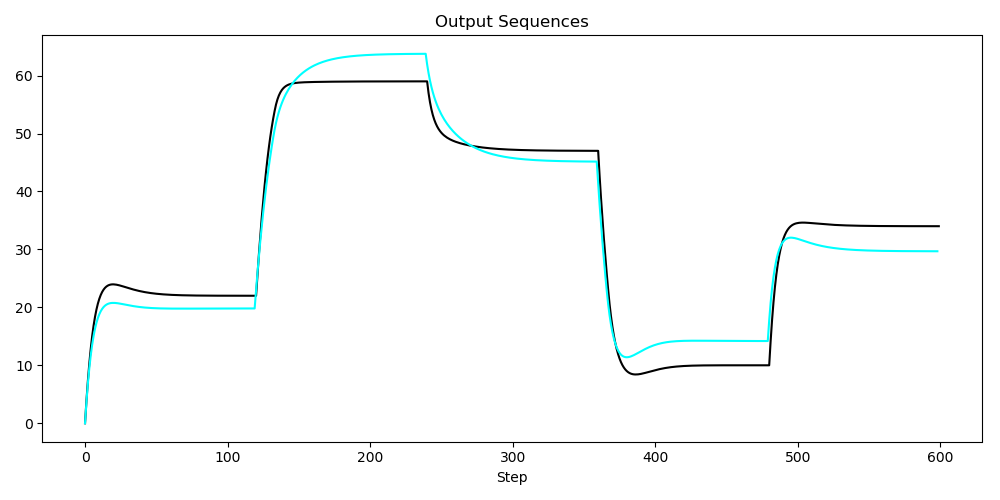

In [9]:
### plot original state data and system model approximation

# evaluate output of learned model
opt_weights = w_hist[-1]
print(opt_weights)    # cost of 0.0556; weights = [0.7749408, 0.9390561, 0.03648759]

T = states.shape[1]
system_model = np.zeros(T-1)
    
for ii in range(1,T-1):
    system_model[ii] = opt_weights[0] + opt_weights[1]*system_model[ii-1] + opt_weights[2]*actions[0,ii]


import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy

# initialize figure
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(111); 

# plot data
ax1.plot(np.arange(np.size(system_model)),system_model.flatten(),c = 'cyan',linewidth = 1.5,label = 'System Model',zorder = 2)
ax1.plot(np.arange(np.size(states)),states.flatten(),c = 'black',linewidth = 1.5,label = 'Original States',zorder = 1)

# label axes and title
ax1.set_title('Output Sequences')
ax1.set_xlabel('Step')

plt.show()

#### <span style="color:#a50e3e;">Exercise 2: </span>  Train an unregularized PID controller for the cruise control problem

In this exercise you will tune the parameters of a PID controller automatically so that the system model trained in the previous exercise matches the example set point sequence shown below.  Note: you need to have finished the previous exercise in order to properly solve this one!

<IPython.core.display.Javascript object>


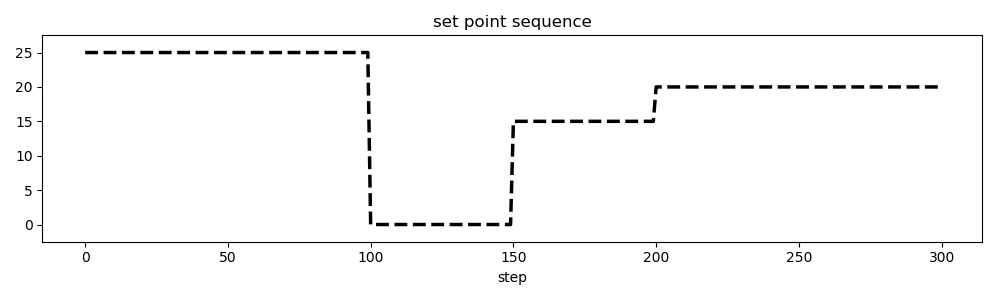

In [10]:
# load in set point sequence
csvname = 'datasets/cruise_setpoints.csv'
set_points = np.loadtxt(csvname,delimiter = ',')[np.newaxis,:]

# plot set point sequence
plotter.plot_setpoints(set_points)

Implement a `Pythonic` version of the PID controller Least Squares cost function discussed in the [course notes](https://www.dropbox.com/s/m6456ze0fd8kaf8/system_identification_pid_notes.pdf?dl=0).  You should be able to learn an action / state sequence pair so that your system model responds fairly well to the input set point sequence.  The image below shows the results of an action/state sequence pair learned by a fully tuned PID controller.  The top panel shows the set point sequence in dashed black, with the state sequence defined by the controller in blue.  The bottom panel shows the corresponding action sequence defined by the controller. 

A few notes: 
- For this exercise you need not worry about regularizing either the state or action sequences when training the controller - simply tune it as best as you can.


- Even though a PID controller is technically a Recurrent Network (which can be slow to train), here we only deal with a fairly small dataset of set points and there only 4 parameters to tune - so you can apply the simplest kind of first order algorithm to properly minimize the controller cost (e.g., a full batch gradient descent optimizer). 

<figure>
<p>
<img src= 'images/PID_1.png' width="150%" height="150%" alt=""/>
</p>
</figure>

In [42]:
# inner loop gradient descent function to tune weights

V = [0.8188113,0.93756861,0.03687846] # optimal weights for system model, from problem 1


def g(w,a_train,s_train):
    ''' 
    Least squares cost function 

    Incorporating PID weights into system model

    '''
    
    J = 0
    T = set_points.shape[1]
    dt = 1 # time is given in "steps"
    
    Perror = 0
    Ierror = 0
    Derror = 0
    last_error = 0
    
    action = 0
    state = 0    
    last_action = 0
    last_state = 0
    
    for ii in range(1,T-1):
        
        Perror = s_train[0,ii] - last_state
        Ierror = Ierror + (dt)*Perror
        Derror = (Perror - last_error) / dt
        
        action = w[0] + w[1]*Perror + w[2]*Ierror + w[3]*Derror # current action from PID controller
        state = V[0] + V[1]*last_state + V[2]*last_action # current state from system model
              
        J = J + (V[0] + V[1]*state + V[2]*action - s_train[0,ii+1])**2
        
        last_state = state
        last_action = action
        last_error = Perror
    
    J = J/(T-1)
    
    return J    

# optimize PID weights
alpha = 0.2
max_its = 500
verbose = True
PIDweights = np.asarray([0.0,20.0,1.0,1.0])

PIDw_hist, train_hist = optimizers.gradient_descent(g,PIDweights,[],set_points,alpha,max_its,verbose)

print(PIDw_hist[-1])



step 2 done in 0.4 secs, train cost = 8.3796
step 3 done in 0.4 secs, train cost = 7.5704
step 4 done in 0.4 secs, train cost = 7.4094
step 5 done in 0.3 secs, train cost = 8.4462
step 6 done in 0.4 secs, train cost = 7.2274
step 7 done in 0.4 secs, train cost = 6.6816
step 8 done in 0.3 secs, train cost = 6.4296
step 9 done in 0.4 secs, train cost = 6.2945
step 10 done in 0.4 secs, train cost = 6.1743
step 11 done in 0.4 secs, train cost = 6.0635
step 12 done in 0.3 secs, train cost = 5.9736
step 13 done in 0.3 secs, train cost = 5.8562
step 14 done in 0.3 secs, train cost = 5.7687
step 15 done in 0.4 secs, train cost = 5.6875
step 16 done in 0.5 secs, train cost = 5.6121
step 17 done in 0.3 secs, train cost = 5.5417
step 18 done in 0.3 secs, train cost = 5.4758
step 19 done in 0.4 secs, train cost = 5.4139
step 20 done in 0.4 secs, train cost = 5.3556
step 21 done in 0.5 secs, train cost = 5.3005
step 22 done in 0.4 secs, train cost = 5.2481
step 23 done in 0.4 secs, train cost = 5.1

step 179 done in 0.5 secs, train cost = 3.6898
step 180 done in 0.4 secs, train cost = 3.6886
step 181 done in 0.3 secs, train cost = 3.6873
step 182 done in 0.3 secs, train cost = 3.6861
step 183 done in 0.3 secs, train cost = 3.6849
step 184 done in 0.4 secs, train cost = 3.6838
step 185 done in 0.4 secs, train cost = 3.6826
step 186 done in 0.4 secs, train cost = 3.6815
step 187 done in 0.5 secs, train cost = 3.6804
step 188 done in 0.3 secs, train cost = 3.6793
step 189 done in 0.4 secs, train cost = 3.6782
step 190 done in 0.4 secs, train cost = 3.6771
step 191 done in 0.4 secs, train cost = 3.6761
step 192 done in 0.3 secs, train cost = 3.675
step 193 done in 0.3 secs, train cost = 3.674
step 194 done in 0.4 secs, train cost = 3.673
step 195 done in 0.4 secs, train cost = 3.672
step 196 done in 0.4 secs, train cost = 3.6711
step 197 done in 0.4 secs, train cost = 3.6701
step 198 done in 0.4 secs, train cost = 3.6692
step 199 done in 0.5 secs, train cost = 3.6682
step 200 done in 

step 354 done in 0.5 secs, train cost = 3.6124
step 355 done in 0.4 secs, train cost = 3.6123
step 356 done in 0.4 secs, train cost = 3.6122
step 357 done in 0.4 secs, train cost = 3.6121
step 358 done in 0.4 secs, train cost = 3.612
step 359 done in 0.5 secs, train cost = 3.6119
step 360 done in 0.5 secs, train cost = 3.6119
step 361 done in 0.4 secs, train cost = 3.6118
step 362 done in 0.4 secs, train cost = 3.6117
step 363 done in 0.4 secs, train cost = 3.6116
step 364 done in 0.5 secs, train cost = 3.6115
step 365 done in 0.4 secs, train cost = 3.6114
step 366 done in 0.4 secs, train cost = 3.6113
step 367 done in 0.4 secs, train cost = 3.6113
step 368 done in 0.4 secs, train cost = 3.6112
step 369 done in 0.5 secs, train cost = 3.6111
step 370 done in 0.4 secs, train cost = 3.611
step 371 done in 0.4 secs, train cost = 3.611
step 372 done in 0.4 secs, train cost = 3.6109
step 373 done in 0.4 secs, train cost = 3.6108
step 374 done in 0.5 secs, train cost = 3.6107
step 375 done in

<IPython.core.display.Javascript object>


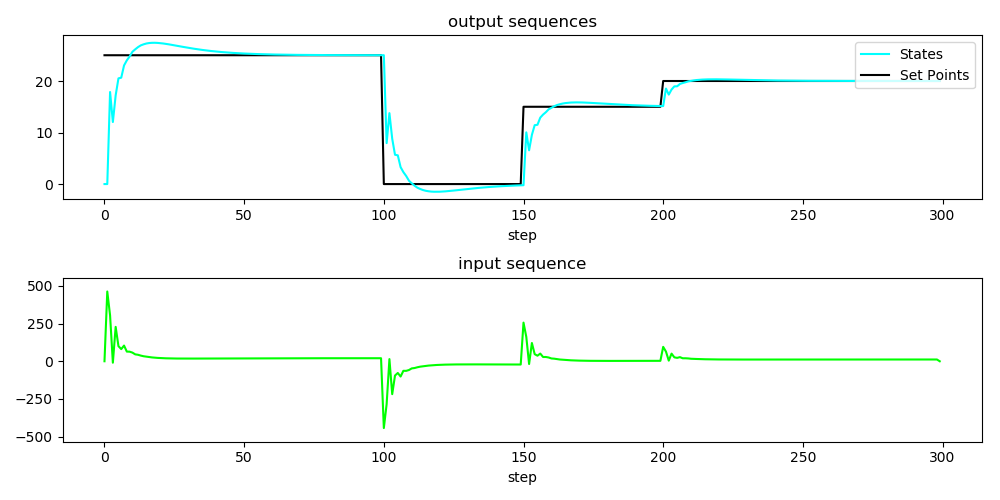

In [43]:
# use optimized weights to calculate response to set points trajectory
opt_PIDw = PIDw_hist[-1] 
# one output of optimization: [-0.5007376  10.84841231  0.67129862  6.98833215], cost of 3.6062

T = set_points.shape[1]

states = np.zeros(T)
actions = np.zeros(T)

dt = 1 # time is given in "steps"
    
Perror = 0
Ierror = 0
Derror = 0
last_error = 0
 
last_action = 0
last_state = 0

for ii in range(1,T-1):

    Perror = set_points[0,ii] - last_state
    Ierror = Ierror + (dt)*Perror
    Derror = (Perror - last_error) / dt

    actions[ii] = opt_PIDw[0] + opt_PIDw[1]*Perror + opt_PIDw[2]*Ierror + opt_PIDw[3]*Derror # current action from PID controller
    states[ii+1] = V[0] + V[1]*last_state + V[2]*actions[ii] # current state from system model

    last_state = states[ii]
    last_action = actions[ii]
    last_error = Perror


# plot output of PID controller here
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy

# initialize figure
fig = plt.figure(figsize = (10,5))

# create subplot with 3 panels, plot input function in center plot
gs = gridspec.GridSpec(2,1) 
ax1 = plt.subplot(gs[1]); 
ax2 = plt.subplot(gs[0]);

ax1.plot(np.arange(np.size(actions)),actions.flatten(),c = 'lime',linewidth = 1.5)
ax2.plot(np.arange(np.size(states)),states.flatten(),c = 'cyan',linewidth = 1.5,label = 'States',zorder = 2)
ax2.plot(np.arange(np.size(set_points)),set_points.flatten(),c = 'k',linewidth = 1.5,label = 'Set Points',zorder = 1)

# label axes and title
ax1.set_title('input sequence')
ax1.set_xlabel('step')
ax2.set_title('output sequences')
ax2.set_xlabel('step')

# set viewing limits
s1min = np.min(copy.deepcopy(actions))
s1max = np.max(copy.deepcopy(actions))
s1gap = (s1max - s1min)*0.1
s1min -= s1gap
s1max += s1gap
ax1.set_ylim([s1min,s1max])

s2min = np.min(copy.deepcopy(states))
s2max = np.max(copy.deepcopy(states))
s2gap = (s2max - s2min)*0.1
s2min -= s2gap
s2max += s2gap
ax2.legend(loc = 1)

plt.show()

#### <span style="color:#a50e3e;">Exercise 3: </span>  System identification on the two-tank problem 

In this exercise you will create a system model - using a small snippet of cruise control data shown below.  This comes from a real life two-tanks experiment as shown on page 4 of the [course notes](https://www.dropbox.com/s/m6456ze0fd8kaf8/system_identification_pid_notes.pdf?dl=0).  The amount of water allowed into the top tank (per second) - the action sequence $a_t$ - is shown as the black curve in the bottom panel.  In the top panel the *upper* tank water level $s_{1,t}$ is shown in green, and the bottom tank level $s_{2,t}$ is shown in magenta.

<IPython.core.display.Javascript object>


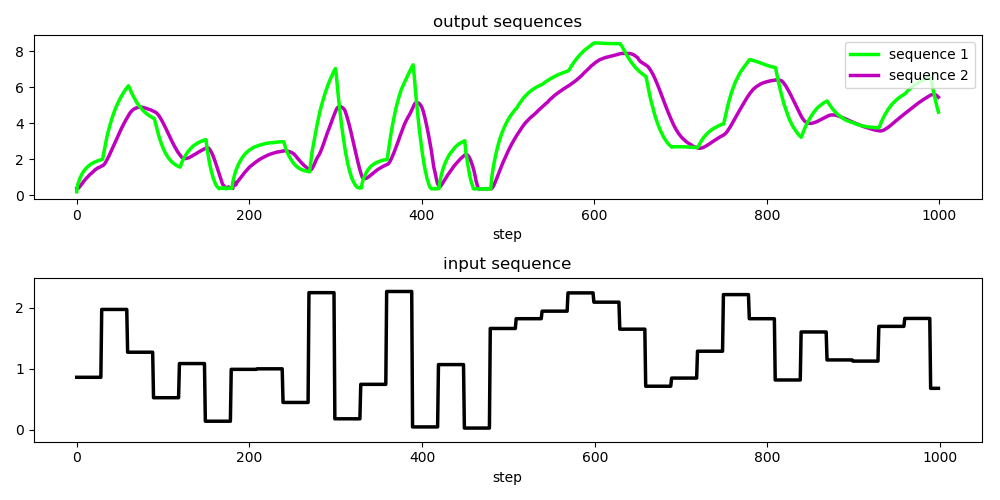

In [13]:
# This code cell will not be shown in the HTML version of this notebook
# load series
data = np.loadtxt(datapath + 'cascaded_tanks_1.csv',delimiter = ',')
actions = data[0:1,1:]
states = data[1:,:]

# plot the test pair
plotter.plot_3fer(actions,states[0],states[1],plot_type = 'continuous')

This system has two $s_{1,t}$ and $s_{2,t}$, hence the system model consists of an equation for each.  The upper tank level $s_{1,t}$ is dependent on its own history and - of course- the amount of water $a_t$ that is poured into it.  A simple linear system model for it then looks like

\begin{equation}
s_{1,t+1} = w_0 + w_1 s_{1,t} + w_2 a_t.
\end{equation}

Since we know that the upper tank drains into the lower one, the simplest sort of system model we can make for the lower tank level $s_{2,t}$ is that it is proportional to its prior value and that of the upper tank, as

\begin{equation}
s_{2,t+1} = w_3 + w_4s_{2,t} + w_5 s_{1,t}.
\end{equation}

Together - using the simplest model for this system we could think of - we have the following two system model equations

\begin{array}
\
s_{1,t+1} = w_0 + w_1 s_{1,t} + w_2 a_t \\
s_{2,t+1} = w_3 + w_4s_{2,t} + w_5 s_{1,t}.
\end{array}

Tune the parameters of this system model $w_0$ through $w_5$ via minimizing a Least Squares cost function, using the data shown above for training (i.e., you need not cut off a chunk of it for validation - use it all for training).  Make sure to plot the fit your model provides on the training data.  You can see this exact system model fit to this exact dataset in the course notes - make sure your fit looks fairly similar.

In [23]:
# least squares function

def g(w,a_train,s_train):
    ''' Least squares cost function'''
    
    J1 = 0
    J2 = 0
    T = s_train.shape[1]
    
    for ii in range(1,T-1):
        J1 = J1 + (w[0] + w[1]*s_train[0,ii] + w[2]*a_train[0,ii] - s_train[0,ii+1])**2 # cost for first tank
        J2 = J2 + (w[3] + w[4]*s_train[1,ii] + w[5]*s_train[0,ii] - s_train[1,ii+1])**2

    J = (J1+J2)/(T-1)

    return J

# gradient descent

weights = np.random.rand(6,1)

alpha = 0.025
max_its = 200
verbose = True

w_hist,train_hist = optimizers.gradient_descent(g,weights,actions,states,alpha,max_its,verbose)

print(w_hist[-1])

step 2 done in 1.3 secs, train cost = 1.2452
step 3 done in 1.3 secs, train cost = 1.119
step 4 done in 1.3 secs, train cost = 1.0634
step 5 done in 1.3 secs, train cost = 1.0135
step 6 done in 1.4 secs, train cost = 0.9662
step 7 done in 1.4 secs, train cost = 0.9213
step 8 done in 1.4 secs, train cost = 0.8787
step 9 done in 1.4 secs, train cost = 0.8383
step 10 done in 1.4 secs, train cost = 0.7999
step 11 done in 1.3 secs, train cost = 0.7634
step 12 done in 1.3 secs, train cost = 0.7288
step 13 done in 1.5 secs, train cost = 0.6958
step 14 done in 1.3 secs, train cost = 0.6645
step 15 done in 1.4 secs, train cost = 0.6348
step 16 done in 1.3 secs, train cost = 0.6066
step 17 done in 1.4 secs, train cost = 0.5797
step 18 done in 1.3 secs, train cost = 0.5542
step 19 done in 1.0 secs, train cost = 0.5299
step 20 done in 1.1 secs, train cost = 0.5068
step 21 done in 0.9 secs, train cost = 0.4848
step 22 done in 1.1 secs, train cost = 0.4639
step 23 done in 1.2 secs, train cost = 0.44

step 179 done in 1.3 secs, train cost = 0.009
step 180 done in 1.3 secs, train cost = 0.0089
step 181 done in 1.3 secs, train cost = 0.0088
step 182 done in 1.3 secs, train cost = 0.0087
step 183 done in 1.3 secs, train cost = 0.0086
step 184 done in 1.3 secs, train cost = 0.0085
step 185 done in 1.3 secs, train cost = 0.0085
step 186 done in 1.3 secs, train cost = 0.0084
step 187 done in 1.3 secs, train cost = 0.0083
step 188 done in 1.3 secs, train cost = 0.0082
step 189 done in 1.3 secs, train cost = 0.0081
step 190 done in 1.2 secs, train cost = 0.0081
step 191 done in 1.3 secs, train cost = 0.008
step 192 done in 1.3 secs, train cost = 0.0079
step 193 done in 1.5 secs, train cost = 0.0078
step 194 done in 1.4 secs, train cost = 0.0078
step 195 done in 1.4 secs, train cost = 0.0077
step 196 done in 1.3 secs, train cost = 0.0076
step 197 done in 1.3 secs, train cost = 0.0076
step 198 done in 1.3 secs, train cost = 0.0075
step 199 done in 1.3 secs, train cost = 0.0074
step 200 done i

<IPython.core.display.Javascript object>


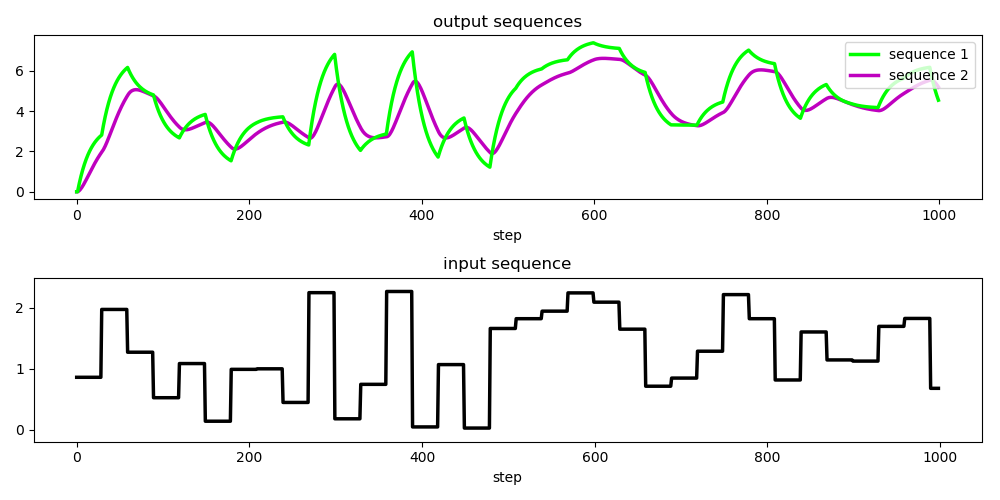

In [25]:
# use optimal weights to simulate system
# [0.04738977, 0.93622524, 0.19261502, 0.02357337, 0.92728438, 0.06336561], cost of 0.0073
opt_weights = w_hist[-1]

T = states.shape[1]
system_model = np.zeros(states.shape)

for ii in range(1,T-1):
    system_model[0,ii+1] = opt_weights[0] + opt_weights[1]*system_model[0,ii] + opt_weights[2]*actions[0,ii]
    system_model[1,ii+1] = opt_weights[3] + opt_weights[4]*system_model[1,ii] + opt_weights[5]*system_model[0,ii]
    
# plot results
plotter.plot_3fer(actions,system_model[0],system_model[1],plot_type = 'continuous')